### Python based viewer tool for "Probabilistic Reasoning over time", EDAP01 Artificial Intelligence
This notebook has been provided to you by Alexander Dürr, teaching assistant on the course, spring term 2021. It is based on the ideas and structure of the original Java skeleton for this assignment, provided by Elin A. Topp. Contact us (elin_anna.topp at cs.lth.se) in case you need help!

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

#heatmap and custom colors
import seaborn as sns 
from matplotlib import cm
from matplotlib.colors import ListedColormap

#for animations, sliders, buttons, etc
#%matplotlib widget
import ipywidgets as widgets
from IPython.display import display,clear_output

#to run the dashboard in the front and the simulation in the back
import threading

### Note: Installing and activating widgets for Jupyter Notebook
To be able to display the visualization (dashboard,animations,etc.) you have to initially install the package  if you don't have it yet

After you did that, you have to enable the widget extension for jupyter notebook 

### Note: Use Jupyter Lab for programming, Jupyter Notebook for visualization (optional)
This command only enables the extension for jupyter notebook and not in jupyter lab! You can edit from the comfort of jupyter lab though and when you feel like using the widgets just go to

Menu bar > Help > Launch Classic Notebook

### Note: Install widgets for Jupyter Lab (optional)
If you want to have the animations in jupyter lab directly, try installing jupyter lab version 1, 2 or 3 and follow the instructions on
https://ipywidgets.readthedocs.io/en/stable/user_install.html#installing-in-jupyterlab-3-0

**If you can't get it working in jupyter labs, just use jupyter notebook.**

#### Provided models
The following cells contain the state, transition and sensor models

In [2]:
# The state model describes the dimensions of the grid and provides methods to transfrom a pose (x, y, h)
# or a position (x, y) into a state i or a sensor reading state r and/or vice versa.

class StateModel:
    
    def __init__(self, rows, cols):
        self.__rows = rows
        self.__cols = cols
        self.__head = 4
        
    def robotStateToXYH(self, s):
        x = s // (self.__cols*self.__head)
        y = (s - x*self.__cols*self.__head ) // self.__head
        h = s % self.__head
        
        return x, y, h;
    
    def xyhToRobotState( self, x, y, h):
        return x*self.__cols*self.__head + y*self.__head + h

    def robotStateToXY( self, s):
        x = s // (self.__cols*self.__head)
        y = (s - x*self.__cols*self.__head ) // self.__head

        return x, y

    def sensorStateToXY( self, s):
        x = s // self.__cols
        y =  s % self.__cols
        
        return x, y

    def xyToSensorState( self, x, y):
        return x*self.__cols+ y
  
    def robotStateToSensorState( self, s):
        return s // self.__head
    
    def getDimensions(self):
        return self.__rows, self.__cols, self.__head

In [3]:
# The transition model contains the transition matrix and some methods for convenience, 
# including transposition

class TransitionModel:
    def __init__(self, stateModel):
        self.__stateModel = stateModel
        self.__rows, self.__cols, self.__head = self.__stateModel.getDimensions()

        self.__dim = self.__rows * self.__cols * self.__head

        self.__matrix = np.zeros(shape=(self.__dim, self.__dim), dtype=float)
        
        for i in range(self.__dim):
            x, y, h = self.__stateModel.robotStateToXYH( i)
            for j in range(self.__dim):
                nx, ny, nh = self.__stateModel.robotStateToXYH( j)
                

                if abs( x-nx) + abs( y-ny) == 1 and \
                    ( nh == 0 and nx == x-1 or nh == 1 and ny == y+1 or \
                    nh == 2 and nx == x+1 or nh == 3 and ny == y-1) :
                    
                    if nh == h :
                        self.__matrix[i,j] = 0.7

                    else :
                        if x != 0 and x != self.__rows-1 and y != 0 and y != self.__cols-1 :
                            self.__matrix[i,j] = 0.1
                    
                        elif h == 0 and x == 0 and y != 0 and y != self.__cols-1 or \
                             h == 1 and x != 0 and x != self.__rows-1 and y == self.__cols-1 or \
                             h == 2 and x == self.__rows-1 and y != 0 and y != self.__cols-1 or \
                             h == 3 and x != 0 and x != self.__rows-1 and y == 0 :
                        
                            self.__matrix[i,j] = 1.0 / 3.0
                            
                        elif h != 0 and x == 0 and y != 0 and y != self.__cols-1 or \
                             h != 1 and x != 0 and x != self.__rows-1 and y == self.__cols-1 or \
                             h != 2 and x == self.__rows-1 and y != 0 and y != self.__cols-1 or \
                             h != 3 and x != 0 and x != self.__rows-1 and y == 0 :
                            
                            self.__matrix[i,j] = 0.15
                        
                        elif ( h == 0 or h == 3) and ( nh == 1 or nh == 2) and x == 0 and y == 0 or \
                             ( h == 0 or h == 1) and ( nh == 2 or nh == 3) and x == 0 and y == self.__cols-1 or \
                             ( h == 1 or h == 2) and ( nh == 0 or nh == 3) and x == self.__rows-1 and y == self.__cols-1 or \
                             ( h == 2 or h == 3) and ( nh == 0 or nh == 1) and x == self.__rows-1 and y == 0 :
                                
                            self.__matrix[i,j] = 0.5

                        elif ( h == 1 and nh == 2 or h == 2 and nh == 1) and x == 0 and y == 0 or \
                             ( h == 2 and nh == 3 or h == 3 and nh == 2) and x == 0 and y == self.__cols-1 or \
                             ( h == 0 and nh == 1 or h == 1 and nh == 0) and x == self.__rows-1 and y == 0 or \
                             ( h == 0 and nh == 3 or h == 3 and nh == 0) and x == self.__rows-1 and y == self.__cols-1 :
                            
                            self.__matrix[i,j] = 0.3
                
    # retrieve the number of states represented in the matrix                        
    def getNrOfStates( self):
        return self.__dim

    # get the probability to go from state i to j
    def getTij( self, i, j): 
        return self.__matrix[i,j]

    # get the probability to go from pose (x, y, h) to (X, Y, H)
    def getTxyhToXYH( self, x, y, h, X, Y, H):
        return self.__matrix[stateModel.xyhToRobotState( x, y, h), self.__stateModel.xyhToRobotState( X, Y, H)]

    # get the entire matrix
    def getT( self): 
        return self.__matrix.copy()
    
    # get the transposed transition matrix
    def getT_transp( self):
        transp = np.transpose(self.__matrix)
        return transp
    
    # plot matrix as a heat map
    def plotTMatrix(self):
        plt.matshow(self.__matrix)
        plt.colorbar()
        plt.show()

In [4]:
# The observation model contains the diagonals (stored as vectors) of the observation 
# matrices for each possible sensor reading
# The last of these vectors contains the probabilities for the sensor to produce nothing

class ObservationModel:
    def __init__( self, stateModel) :

        self.__stateModel = stateModel
        self.__rows, self.__cols, self.__head = stateModel.getDimensions()

        self.__dim = self.__rows * self.__cols * self.__head
        self.__numOfReadings = self.__rows * self.__cols + 1

        self.__vectors = np.ones(shape=(self.__numOfReadings, self.__dim))
        
        
        for o in range(self.__numOfReadings-1) :
            sx, sy = self.__stateModel.sensorStateToXY(o)

            for i in range( self.__dim) :
                x, y = self.__stateModel.robotStateToXY(i)
                self.__vectors[o,i] = 0.0
                
                if x == sx and y == sy :
                    self.__vectors[o,i] = 0.1 
                elif ( x == sx+1 or x == sx-1) and y == sy :
                    self.__vectors[o,i] = 0.05
                elif ( x == sx+1 or x == sx-1) and (y == sy+1 or y == sy-1):
                    self.__vectors[o,i] = 0.05
                elif x == sx and (y == sy+1 or y == sy-1):
                    self.__vectors[o,i] = 0.05 
                elif ( x == sx+2 or x == sx-2) and (y == sy or y == sy+1 or y == sy-1):
                    self.__vectors[o,i] = 0.025
                elif ( x == sx+2 or x == sx-2) and (y == sy+2 or y == sy-2):
                    self.__vectors[o,i] = 0.025
                elif ( x == sx or x == sx+1 or x == sx-1) and (y == sy+2 or y == sy-2):
                    self.__vectors[o,i] = 0.025

                self.__vectors[self.__numOfReadings-1,i] -= self.__vectors[o,i]; #sensor reading "nothing"

    # get the number of possible sensor readings
    def getNrOfReadings( self) :
        return self.__numOfReadings

    # get the probability for the sensor to have produced reading "reading" when in state i
    def getOri( self, reading, i) :
        return self.__vectors[reading,i]

    # get the entire vector with probabilies to have produced reading "reading"
    # use None for "no reading"
    def getOr( self, reading) :
        if( reading == None): reading = self.__numOfReadings-1
        return self.__vectors[reading,:]

    # get the probability to have produced reading <rX, rY> when in position <x, y>
    # send in rX or rY as None to get teh values for "no reading"
    def getOrXY( self, rX, rY, x, y) :
        if rX == None or rY == None:
            return self.__vectors[self.__numOfReadings-1, x*self.__cols*self.__head + y*self.__head]
        return self.__vectors[rX*self.__cols + rY, x*self.__cols*self.__head + y*self.__head]

    # plot the vectors as heat map(s)
    def plotODiags(self):
        plt.matshow(self.__vectors)
        plt.colorbar()
        plt.show()

#### Robot Simulator, Filter and Localizer
In the following two cells you need to add your implementation for RobotSimulator and Filtering approach, as well as for the update method of the Localizer!

In [5]:
# Add your Robot Simulator here
class RobotSim:   
    
    # returns a new state given the current one
    def newState(state, transitionModel):
        
        probs = transitionModel.getT()[state]
        possibleStates = range(len(probs))
        
        newState = random.choices(possibleStates, probs)
        
        return newState[0]
        
        
    # returns a sensor reading given the current state
    def sensorReading(trueState, stateModel, observationModel):
        
        dimension = observationModel.getNrOfReadings()

        probs = np.zeros(dimension)
        
        [trueX,trueY] = stateModel.robotStateToXY(trueState)

        for i in range(dimension):
            [tempX,tempY] = stateModel.sensorStateToXY(i)
            probs[i] = observationModel.getOrXY(tempX,tempY,trueX,trueY)
        
        choices = list(range(len(probs)-1))
        choices += [None]
        
        reading = random.choices(choices, probs)
        
        return reading[0]
    

# Add your Filtering approach here (or within the Localiser, that is your choice!)
class HMMFilter:
    
    # produces a vector of probabilities that the robot is in a specific state
    def forwardFilter(probs, sensorReading, observationModel, transitionModel):
        
        #prepare matrixes
        O = np.diag(observationModel.getOr(sensorReading))
        Tt = transitionModel.getT_transp()
        
        probs = O@Tt@probs
        
        #normalization
        alpha = np.linalg.norm(probs)
        
        return (1/alpha)*probs
        


In [6]:
# The Localizer binds the models together and controls the update cycle in its "update" method. 

class Localizer:
    def __init__(self, stateModel) :
    
        self.__stateModel = stateModel
        self.__rows, self.__cols, self.__head = stateModel.getDimensions()
        
        self.__tm = TransitionModel(self.__stateModel)
        self.__om = ObservationModel(self.__stateModel)
         
        # change in initialise in case you want to start out with something else...
        self.initialise()
        
        
    # for convenience, one can also ask the StateModel
    def getNumRows(self):
        return self.__rows

    # for convenience, one can also ask the StateModel
    def getNumCols(self):
        return self.__cols
    
    # for convenience, one can also ask the StateModel
    def getNumHead(self):
        return self.__head

    # retrieve the transition model that we are currently working with
    def getTransitionModel(self):
        return self.__tm

    # retrieve the observation model that we are currently working with
    def getObservationModel(self): 
        return self.__om

    # the current true pose (x, y, h) that should be kept in the local variable __trueState
    def getCurrentTruePose(self): 
        x, y, h = self.__stateModel.robotStateToXYH(self.__trueState)
        return x, y, h

    # the current probability distribution over all states
    def getCurrentProbDist(self): 
        return self.__probs

    # the current sensor reading. "Nothing" is expressed as None
    def getCurrentReading(self): 
        ret = None
        
        if self.__sense != None : 
            ret = self.__stateModel.sensorStateToXY(self.__sense)
    
        return ret;
    
    # get the currently most likely position, based on single most probable pose     
    def getEstimatedPosition(self):
        index = np.argmax( self.__probs)
        return self.__stateModel.robotStateToXY( index)
    
    def getEvaluationMeasures(self):
        return self.__totalError, self.__correctEstimates

    
################################### Here you need to really fill in stuff! ##################################
# if you want to start with something else, change the initialisation here!

    # (re-)initialise for a new run without change of size
    def initialise(self):
        self.__trueState = random.randint(0, self.__rows*self.__cols*self.__head-1)
        self.__sense = None
        self.__probs = np.ones(self.__rows*self.__cols*self.__head) / (self.__rows*self.__cols*self.__head)
        
        # simple evaluation measures that go into the visualisation, add more if you like!
        # räkna ut manhattan
        self.__totalError = 0.0
        self.__correctEstimates = 0
        

#  Implement the update cycle: 
#  - robot moves one step, generates new state / pose
#  - sensor produces one reading based on the true state / pose
#  - filtering approach produces new probability distribution based on
#  sensor reading, transition and sensor models
#
#  Add an evaluation in terms of Manhattan distance (average over time) and "hit rate"
#  you can do that here or in the simulation method of the visualisation, using also the 
#  options of the dashboard to show errors...
#
#  Report back to the caller (viewer):
#  Return 
#  - true if sensor reading was not "nothing", else false,
#  - AND the three values for the (new) true pose (x, y, h),
#  - AND the two values for the (current) sensor reading (if not "nothing")
#  - AND the new probability distribution

    def update(self):
        
        # robot sim takes 1 step
        self.__trueState = RobotSim.newState(self.__trueState, self.__tm)
        TrueStateX, TrueStateY, TrueStateHeading = self.__stateModel.robotStateToXYH(self.__trueState)
        
        # robot sim produces sensor reading
        ret = False # in case the sensor reading is "nothing" this is kept...
        sensorReadingX = -1
        sensorReadingY = -1
        self.__sense = RobotSim.sensorReading(self.__trueState, self.__stateModel, self.__om)
                        
        if self.__sense != None :
            sensorReadingX, sensorReadingY = self.__stateModel.sensorStateToXY(self.__sense)
            ret = True
            
        # approximation of location is calculated
        probs = HMMFilter.forwardFilter(self.__probs, self.__sense, self.__om, self.__tm)
        self.__probs = probs
        
        #evaluation (correctEstimates funkar inte)
        [estX, estY] = self.getEstimatedPosition()
        [trueX, trueY, trueH] = self.getCurrentTruePose()
        manhattan = abs(trueX - estX) + abs(trueY - estY)
        self.__totalError += manhattan
        if [estX, estY] == [trueX, trueY]:
            self.__correctEstimates += 1
        
        return ret, TrueStateX, TrueStateY, TrueStateHeading, sensorReadingX, sensorReadingY, probs


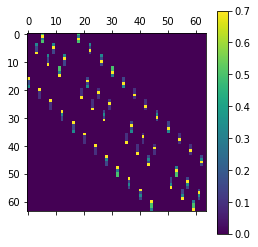

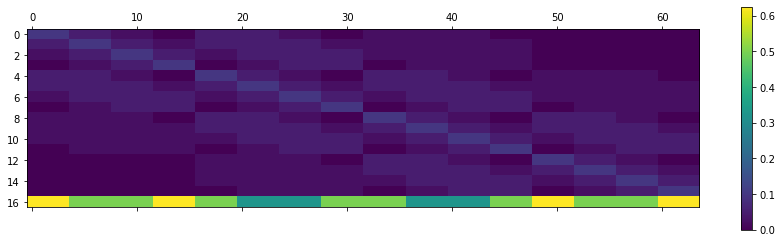

In [7]:
# Testing the models

states = StateModel(4, 4)
loc = Localizer(states)
tMat = loc.getTransitionModel()
sVecs = loc.getObservationModel()
tMat.plotTMatrix()
sVecs.plotODiags()

#print(sVecs.getOr(0))
#print(sVecs.getOr(None))

#print(loc.update())

vals = loc.update()

#### Visualisation, no changes needed

In [8]:
'''
In this cell is *nothing* to change for you.
If you are interested, feel free to check out the code as an example of
how to implement widgets in jupyter notebook.
'''

stop_thread = True
thread = None
mutex = threading.Lock()



class Dashboard:

    def __init__(self,ROOM_HEIGHT,ROOM_WIDTH):
        
        self.slider_h = widgets.IntSlider(min=4,max=10,step=1,description='Height',value=ROOM_HEIGHT)
        self.slider_w = widgets.IntSlider(min=4,max=10,step=1,description='Width',value=ROOM_WIDTH)
        self.slider_h.observe(self.on_slider_change, names='value')
        self.slider_w.observe(self.on_slider_change, names='value')
        
        self.out=widgets.Output(layout=widgets.Layout(height='720px', width = '720px', border='solid'))
        
        #self.shellout=widgets.Output()
        
        self.btn_st = widgets.Button(description='Show transitions')
        self.btn_st.on_click(self.btn_st_eventhandler)
        
        self.btn_ss = widgets.Button(description='Show sensor')
        self.btn_ss.on_click(self.btn_ss_eventhandler)
        
        self.btn_if = widgets.Button(description='Init filter')
        self.btn_if.on_click(self.btn_if_eventhandler)
        
        self.btn_os = widgets.Button(description='One step')
        self.btn_os.on_click(self.btn_os_eventhandler)
        
        self.btn_go = widgets.Button(description='Go')
        self.btn_go.on_click(self.btn_go_eventhandler)
        
        self.btn_sp = widgets.Button(description='Stop')
        self.btn_sp.on_click(self.btn_sp_eventhandler)
        
        self.input_widgets = widgets.HBox([self.slider_h, self.slider_w])
        self.lhs = widgets.VBox([self.btn_st, self.btn_ss])
        self.rhs = self.out
        self.middle = widgets.HBox([self.lhs, self.rhs])
        self.animation = widgets.HBox([self.btn_if, self.btn_os, self.btn_go, self.btn_sp])
        self.db = widgets.VBox([self.input_widgets, self.middle, self.animation])
        
        # setup of the initial simulation
        room = StateModel(self.slider_h.value, self.slider_w.value)
        model = Localizer(room)
        self.room = room
        self.model = model
        self.total_error = 0
        self.correct_guesses = 0
        self.nbr_of_moves = 0
        self.initialised = False
        
        self.plot_time = 0.01*self.model.getNumRows()*self.model.getNumCols()*self.model.getNumHead()
        
        # transition matrix and observation matrix visualization
        self.transition_step = 0
        self.observation_step = model.getNumRows()*model.getNumCols()
        
    def on_slider_change(self, obj):
        global thread
        global stop_thread
        global mutex
        
        mutex.acquire()
        try:    
            # if you change the dimensions of the room we have to stop the ongoing simulation thread
            if thread != None:
                stop_thread=True
                time.sleep(0.1)
                thread.join()
                thread = None
            # setup a new room and model
            room = StateModel(self.slider_h.value, self.slider_w.value)
            model = Localizer(room)
            self.room = room
            self.model = model
            # reset the counters for steps, accuracy, etc.
            self.total_error = 0
            self.correct_guesses = 0
            self.nbr_of_moves = 0
            
            self.plot_time = 0.01*self.model.getNumRows()*self.model.getNumCols()*self.model.getNumHead()
            
            self.initialised = False

        finally:
            mutex.release()
        
    def btn_st_eventhandler(self, obj):
        global mutex
        mutex.acquire()
        try:
            #print('Hello from the {} button!'.format(obj.description))
            visualizationroom = np.empty(shape=(self.model.getNumRows()*3, self.model.getNumCols()*3))
            visualizationroom[:] = np.NaN
            visrow_iter = [0,1,2,1]
            viscol_iter = [1,2,1,0]

            # CHECK HERE!!!
            That = self.model.getTransitionModel().getT()[self.transition_step][:]

            for r in range(self.model.getNumRows()):
                for c in range(self.model.getNumCols()):
                    for dir in range(4):
                        state = self.room.xyhToRobotState( r, c, dir)
                        '''
                        increase dir > increase col > increase row    
                        visrow = 1 2 1 0 | 1 2 1 0 | ... | 4 5 4 3
                        viscol = 2 1 0 1 | 5 4 3 4 | ... | 2 1 0 1
                        '''
                        visrow = r*3+visrow_iter[dir]
                        viscol = c*3+viscol_iter[dir]
                        visualizationroom[visrow,viscol]=That[state]
                        if self.transition_step == state:
                            visualizationroom[visrow, viscol] = 129/256*2
            plt.close('all')
            plt.figure(1,figsize=(10, 10))
            plot = create_map_with_heading(plt, visualizationroom)
            
            if plot == None:
                pass
            else:
                self.update_plt(plot, True)
                
            self.transition_step += 1
            if self.transition_step >= That.size:
                self.transition_step = 0
        finally:
            mutex.release()

    def btn_ss_eventhandler(self, obj):
        global mutex
        mutex.acquire()
        try:
            #print('Hello from the {} button!'.format(obj.description))
            visualizationroom = np.empty(shape=(self.model.getNumRows()*3, self.model.getNumCols()*3))
            visualizationroom[:] = np.NaN
            visrow_iter = [0,1,2,1]
            viscol_iter = [1,2,1,0]

            row = (self.observation_step) // self.model.getNumCols()
            col = (self.observation_step) % self.model.getNumCols()
            for r in range(self.model.getNumRows()):
                for c in range(self.model.getNumCols()):
                    for dir in range(4):
                        state = self.room.xyhToRobotState(r, c, dir)
                        '''
                        increase dir > increase col > increase row    
                        visrow = 1 2 1 0 | 1 2 1 0 | ... | 4 5 4 3
                        viscol = 2 1 0 1 | 5 4 3 4 | ... | 2 1 0 1
                        '''
                        visrow = r*3+visrow_iter[dir]
                        viscol = c*3+viscol_iter[dir]
                        visualizationroom[visrow,viscol]=self.model.getObservationModel().getOri( self.observation_step, state)
                        if self.observation_step == self.room.robotStateToSensorState( state) \
                            and dir == 0 and self.observation_step != self.model.getNumRows()*self.model.getNumCols():
                            visualizationroom[visrow+1, viscol] = 129/256*2
            plt.close('all')
            plt.figure(1,figsize=(10, 10))
            plot = create_map_with_heading(plt,visualizationroom)
            if plot == None:
                pass
            else:
                self.update_plt(plot, True)

            self.observation_step += 1
            if self.observation_step > (self.model.getNumRows()*self.model.getNumCols()):
                self.observation_step=0
        finally:
            mutex.release()

    def btn_if_eventhandler(self, obj):
        global mutex
        global thread
        global stop_thread

        mutex.acquire()
        try:
            #print('Hello from the {} button!'.format(obj.description))

            # reset the counters for steps, accuracy, etc.
            self.total_error = 0
            self.correct_guesses = 0
            self.nbr_of_moves = 0

            # then we can allow to start a new simulation thread
            stop_thread=False
            self.initialised = True
            
            self.model.initialise()
            
            x, y, h = self.model.getCurrentTruePose()
            pos = [x,y]
            visualizationroom = np.empty(shape=(self.model.getNumRows()*3, self.model.getNumCols()*3))
            visualizationroom[:] = np.NaN
            visrow_iter = [0,1,2,1]
            viscol_iter = [1,2,1,0]
            for r in range(self.model.getNumRows()):
                for c in range(self.model.getNumCols()):
                    for dir in range(4):
                        state = self.room.xyhToRobotState(r,c,dir)
                        '''
                        increase dir > increase col > increase row    
                        visrow = 1 2 1 0 | 1 2 1 0 | ... | 4 5 4 3
                        viscol = 2 1 0 1 | 5 4 3 4 | ... | 2 1 0 1
                        '''
                        visrow = r*3+visrow_iter[dir]
                        viscol = c*3+viscol_iter[dir]
                        visualizationroom[visrow,viscol]=self.model.getCurrentProbDist()[state]
            '''
            0,0 | 1,0 | 0,1 | 1,1 |
            1,1 | 4,1 | 1,4 | 4,4
            '''
            visualizationroom[pos[0]*3+1, pos[1]*3+1] = 256/256*2

            plt.close('all')
            plt.figure(1,figsize=(10, 10))
            plot = create_map_with_heading(plt,visualizationroom)
            
            if plot == None:
                print( "plot is none")
            else:
                self.update_plt(plot, True)
        finally:
            mutex.release()

    def btn_os_eventhandler(self, obj):
        global mutex
        global thread
        try:
            global stop_thread
            if thread != None:
            # if you change the dimensions of the room we have to stop the ongoing simulation thread
                stop_thread=True
                time.sleep(0.1)
                thread.join()
                thread = None
            
            if self.initialised:
                self.update_grid_one_step( True)
                stop_thread = False
            else:
                print("initialise filter first!")
        finally:
            pass
        
    def btn_go_eventhandler(self, obj):
        global mutex
        global thread
        global stop_thread
            
        mutex.acquire()
        try:
            if not self.initialised:
                print("initialize filter first")
                
            else :
                if not stop_thread and thread == None:
                    # if it isn't, then start it.
                    thread = threading.Thread(target=simulation, args=(self,))
                    thread.start()
                
        finally:
            mutex.release()
            
    def btn_sp_eventhandler(self, obj):
        global mutex
        global thread
        global stop_thread

        mutex.acquire()
        try:
            
            if thread != None:
                stop_thread = True
                time.sleep(0.1)
                thread.join()
                thread = None

            print( "thread stopped")
            
            if self.initialised :
                stop_thread = False
            
        finally:
            mutex.release()

    def update_grid_one_step( self, plotting):
        global mutex
        mutex.acquire()
        
        try:
            sensed, trueR, trueC, trueH, sensedR, sensedC, f = self.model.update()
            pos = [trueR, trueC]

            guess_pos = self.model.getEstimatedPosition()
            sensor_reading = None
            if sensed :
                sensor_reading = [sensedR, sensedC]

            visualizationroom = np.empty(shape=(self.model.getNumRows()*3, self.model.getNumCols()*3))
            visualizationroom[:] = np.NaN
            visrow_iter = [0,1,2,1]
            viscol_iter = [1,2,1,0]
            for r in range(self.model.getNumRows()):
                for c in range(self.model.getNumCols()):
                    for dir in range(4):
                        state = self.room.xyhToRobotState(r,c,dir)
                        '''
                        increase dir > increase col > increase row    
                        visrow = 1 2 1 0 | 1 2 1 0 | ... | 4 5 4 3
                        viscol = 2 1 0 1 | 5 4 3 4 | ... | 2 1 0 1
                        '''
                        visrow = r*3+visrow_iter[dir]
                        viscol = c*3+viscol_iter[dir]
                        visualizationroom[visrow,viscol]=f[state]
            '''
            0,0 | 1,0 | 0,1 | 1,1 |
            1,1 | 4,1 | 1,4 | 4,4
            '''
            if not sensor_reading == None:
                visualizationroom[sensor_reading[0]*3+1, sensor_reading[1]*3+1] = 129/256*2
            visualizationroom[guess_pos[0]*3+1, guess_pos[1]*3+1] = 127/256*2
            visualizationroom[pos[0]*3+1, pos[1]*3+1] = 256/256*2

            plt.close('all')
            plt.figure(1,figsize=(10, 10))
            plot = create_map_with_heading(plt,visualizationroom)

            if plot == None:
                pass
            else:
                self.update_plt(plot, plotting)

            #print( sensed, trueR, trueC, trueH, sensedR, sensedC)
            
            # update the total error and correct guesses with something useful for the visualisation

            total_error, correct_guesses = self.model.getEvaluationMeasures() 
            self.total_error = total_error
            self.correct_guesses = correct_guesses
            self.nbr_of_moves += 1
            #räkna ut average manhattan och printa
            
            averageManhattan = self.total_error/self.nbr_of_moves
            
            print('Number of moves: ' + str(self.nbr_of_moves))
            print('Average Manhattan error: ' + str(averageManhattan))
            print('Number of correct guesses ' + str(self.correct_guesses))
            
        
        finally:
            mutex.release()
            pass
        
        
        
    def update_plt(self, plt, plotting):
        with self.out:
            clear_output(wait=True)
            plt.figure(1,figsize=(10, 10))
            if plotting:
                display(plt.show())
            


new simulation started
Number of moves: 1
Average Manhattan error: 4.0
Number of correct guesses 0
Number of moves: 19
Average Manhattan error: 2.6842105263157894
Number of correct guesses 0
thread stopped


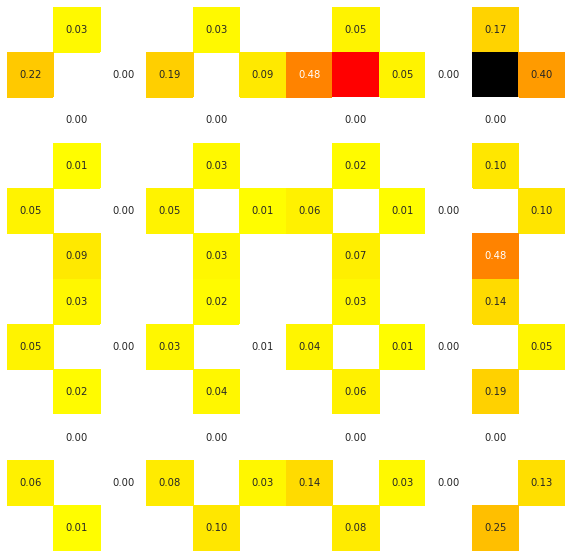

In [9]:
'''
This cell contains the main loop (thread) and simulation control for the filtering
You can activate some more plotting routines at the end of it, but you do not NEED to change anything
'''

def simulation(dash):
    global stop_thread
    print('new simulation started')
    
    sleep_time = dash.plot_time
    while not stop_thread:
    
        try:
            dash.update_grid_one_step(False)
            time.sleep(sleep_time)
        finally:
            pass
            

def main():

    ROOM_HEIGHT = 4
    ROOM_WIDTH = 4

    
    dash = Dashboard(ROOM_HEIGHT, ROOM_WIDTH)
    display(dash.db)

top = cm.get_cmap('autumn', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(0, 1, 128))))
black = np.array([0/256, 0/256, 0/256, 1])
grey = np.array([128/256, 128/256, 128/256, 1])
white = np.array([256/256, 256/256, 256/256, 1])
turquoise = np.array([48/256, 213/256, 200/256, 1])
newcolors[0, :] = white
newcolors[128, :] = grey
newcolors[129, :] = turquoise
newcolors[255, :] = black
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def create_map_with_heading( plt, room):
    ax = sns.heatmap( room, vmin=0, vmax=2, annot=True, fmt=".2f", \
                 xticklabels=False, yticklabels=False,cbar=False, cmap=newcmp)
    for t in ax.texts:
        if t.get_text() == "2.00" or t.get_text() == "0.99" or t.get_text() == "1.01" or t.get_text() == "nan":
            t.set_text("")
    return plt

def create_map(plt,room):
    plt.pcolor(room, cmap='Spectral', edgecolors='k', linewidths=3)
    return plt


 

## if you want to create pictures for the report, maybe these functions could help you with that:

#def create_map(plt,room):
#    plt.pcolor(room, cmap='Spectral', edgecolors='k', linewidths=3)
#    return plt

#def create_empty_map(room):
#    plt.figure(figsize=(6, 6))
#    plt.pcolor(room, cmap='Spectral', edgecolors='k', linewidths=3)
#    return plt
    
#def save_map(room):
#    plt.figure(figsize=(6, 6))
#    plt.pcolor(room, cmap='Spectral', edgecolors='k', linewidths=3)
#    plt.savefig('grid.png')

#def plot_map(room):
#    plt.figure(figsize=(6, 6))
#    plt.pcolor(room, cmap='Spectral', edgecolors='k', linewidths=3)
#    plt.show()


if __name__ == "__main__":
    main()

##### 